In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
df = pd.read_csv("untokenized_df.csv")
print(f"Dataset's shape: {df.shape}")
print(df.columns)

Dataset's shape: (6043, 9)
Index(['index', 'artist', 'lyrics', 'song_name', 'artist_key', 'url',
       'words count', 'unique words count', 'lyricist'],
      dtype='object')


In [70]:
df.value_counts("lyricist")

lyricist
אהוד מנור     363
זאב נחמה      217
שלמה ארצי     205
שלום חנוך     180
אביב גפן      166
             ... 
עילי בוטנר     52
דורון מדלי     52
שאנן סטריט     52
רונה קינן      50
חמי רודנר      50
Length: 64, dtype: int64

In [3]:
example_song = df.query("song_name == 'לקחת את ידי בידך'")["lyrics"].index[0]
df["lyrics"][example_song]

'<s> לקחת את ידי בידך ואמרת לי: <\\s> <s> בואי נרד אל הגן. <\\s> <s> לקחת את ידי בידך ואמרת לי: <\\s> <s> דברים שרואים משם - לא רואים מכאן <\\s> <s>  <\\s> <s> ניגנת לי שיר על הגיטרה וקולך רעד <\\s> <s> רוח בי קמה, רוח שרה, והזמן כאילו עמד <\\s> <s> ואני עוד זוכרת כל טעם וריח <\\s> <s> את חלקת השדה לאור הירח <\\s> <s> קול התן מן הואדי וכובד הפרי בבוסתן, <\\s> <s> דברים שרואים משם לא רואים מכאן. <\\s> <s>  <\\s> <s> הייתי לבדי ודרכי אבדה לי <\\s> <s> ובאת, באת לי בזמן. <\\s> <s> הייתי לבדי ודרכי אבדה לי <\\s> <s> דברים שרואים משם לא רואים מכאן. <\\s> <s>  <\\s> <s> נתת לי יד, הראית לי דרך להרבה דברים <\\s> <s> הבאת חיוך יפה כמו פרח וכח להאמין. <\\s> <s> ואני עוד זוכרת את השיר ששרת <\\s> <s> את החלק הטוב מכל מה שאמרת. <\\s> <s> היי, מלאך ושטן, התשוב לעצור את הזמן <\\s> <s> דברים שרואים משם לא רואים מכאן. <\\s> '

In [4]:
# fixing tags to be in the same format of word2vec dictionary
df["lyrics"] = df["lyrics"].apply(lambda x: x.replace("<s>", "").replace("<\\s>", "</s>").replace("</s></s>", "</s>"))
df["lyrics"][example_song]

' לקחת את ידי בידך ואמרת לי: </s>  בואי נרד אל הגן. </s>  לקחת את ידי בידך ואמרת לי: </s>  דברים שרואים משם - לא רואים מכאן </s>   </s>  ניגנת לי שיר על הגיטרה וקולך רעד </s>  רוח בי קמה, רוח שרה, והזמן כאילו עמד </s>  ואני עוד זוכרת כל טעם וריח </s>  את חלקת השדה לאור הירח </s>  קול התן מן הואדי וכובד הפרי בבוסתן, </s>  דברים שרואים משם לא רואים מכאן. </s>   </s>  הייתי לבדי ודרכי אבדה לי </s>  ובאת, באת לי בזמן. </s>  הייתי לבדי ודרכי אבדה לי </s>  דברים שרואים משם לא רואים מכאן. </s>   </s>  נתת לי יד, הראית לי דרך להרבה דברים </s>  הבאת חיוך יפה כמו פרח וכח להאמין. </s>  ואני עוד זוכרת את השיר ששרת </s>  את החלק הטוב מכל מה שאמרת. </s>  היי, מלאך ושטן, התשוב לעצור את הזמן </s>  דברים שרואים משם לא רואים מכאן. </s> '

In [5]:
print(df["lyrics"][example_song].replace("</s>", "\n"))

 לקחת את ידי בידך ואמרת לי: 
  בואי נרד אל הגן. 
  לקחת את ידי בידך ואמרת לי: 
  דברים שרואים משם - לא רואים מכאן 
   
  ניגנת לי שיר על הגיטרה וקולך רעד 
  רוח בי קמה, רוח שרה, והזמן כאילו עמד 
  ואני עוד זוכרת כל טעם וריח 
  את חלקת השדה לאור הירח 
  קול התן מן הואדי וכובד הפרי בבוסתן, 
  דברים שרואים משם לא רואים מכאן. 
   
  הייתי לבדי ודרכי אבדה לי 
  ובאת, באת לי בזמן. 
  הייתי לבדי ודרכי אבדה לי 
  דברים שרואים משם לא רואים מכאן. 
   
  נתת לי יד, הראית לי דרך להרבה דברים 
  הבאת חיוך יפה כמו פרח וכח להאמין. 
  ואני עוד זוכרת את השיר ששרת 
  את החלק הטוב מכל מה שאמרת. 
  היי, מלאך ושטן, התשוב לעצור את הזמן 
  דברים שרואים משם לא רואים מכאן. 
 


## Using API to segment the songs

We use the API provided by https://www.langndata.com/heb_parser to segment the lyrics.
It uses [YAP](https://github.com/onlplab/yap), a tool written in Go, with the following features:
- Tokenizer

- Segmentation

- Lemmas

- Part-of-speech

- Dependency tree

- Morphological analyzer

- Lattices

YAP is based on the work of Amir More and Amit Seker, developed at the ONLP research lab and led by Dr. Reut Tsarfaty, from the Department of Computer Science and Engineering, Bar-Ilan University.


The API is free to use, but requires registration, and has the following limitations:
1. 1 call per 3 seconds
2. 250 words max per call
3. Request length cannot exceed 1024 characters

### Words / Characters lengths statistics
The following statistics are calculated on the untokenized lyrics, assuming EOS token (</s>) is present.

In [6]:
char_count = [len(s) for s in df["lyrics"].tolist()]
char_count = np.array(char_count)
print("Character count statistics:")
print(f"Mean: {char_count.mean()}, Std: {char_count.std()}, Min: {char_count.min()}, Max: {char_count.max()}")

song_lengths = [len(s.strip().split(" ")) for s in df["lyrics"].tolist()]
song_lengths = np.array(song_lengths)
print("Song word count statistics:")
print(f"Mean: {song_lengths.mean()}, Std: {song_lengths.std()}, Min: {song_lengths.min()}, Max: {song_lengths.max()}")

Character count statistics:
Mean: 787.5217607148767, Std: 362.8889967237251, Min: 78, Max: 4726
Song word count statistics:
Mean: 187.38077114016218, Std: 83.58893577867448, Min: 15, Max: 1051


In [7]:
print(f"Number of songs with more than 1024 characters: {np.sum(char_count > 1024)}")
print(f"Number of songs with more than 250 words: {np.sum(song_lengths > 250)}")
print(
    f"Number of songs with more than 1024 characters or 250 words: {np.sum(np.logical_or(char_count > 1024, song_lengths > 250))}")

Number of songs with more than 1024 characters: 1088
Number of songs with more than 250 words: 991
Number of songs with more than 1024 characters or 250 words: 1125


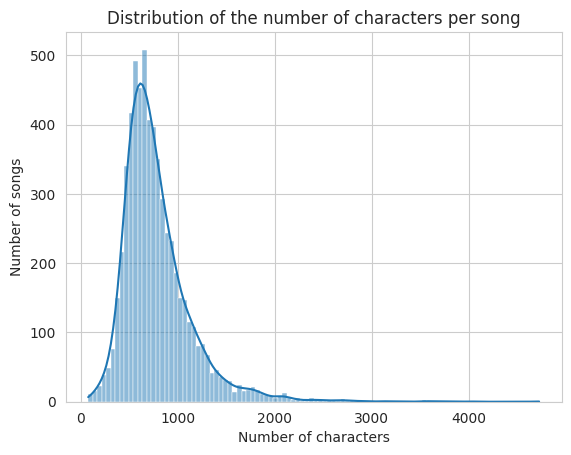

In [8]:
sns.histplot(char_count, bins=100, kde=True)
plt.title("Distribution of the number of characters per song")
plt.xlabel("Number of characters")
plt.ylabel("Number of songs")
plt.show()

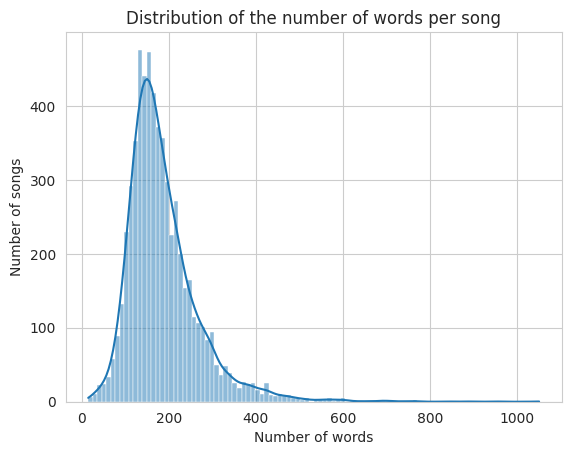

In [9]:
sns.histplot(song_lengths, bins=100, kde=True)
plt.title("Distribution of the number of words per song")
plt.xlabel("Number of words")
plt.ylabel("Number of songs")
plt.show()

### Segmentation
The results show that most of the songs are short, and the number of words per song is usually less than 250.
This is an encouraging figure, since in the future when training AlephBERT, we be limited to 512 inputs.


We decided to split the songs into chunks of no more than 250 words, and no more than 1024 characters.


In [10]:
API_token = "5e269f277bfcf9837ccd16181afe9fe0"

In [11]:
text = df["lyrics"][example_song]
# Escape double quotes in JSON.
text = text.replace(r'"', r'\"')
url = f'https://www.langndata.com/api/heb_parser?token={API_token}'
_json = '{"data":"' + text + '"}'
headers = {'content-type': 'application/json'}
r = requests.post(url, data=_json.encode('utf-8'), headers={'Content-type': 'application/json; charset=utf-8'})
print(f"Tokenized text: {r.json()['tokenized_text']}")
print(f"Segmented text: {r.json()['segmented_text']}")
print(f"lemmatized text: {r.json()['lemmas']}")

Tokenized text: לקחת את ידי בידך ואמרת לי בואי נרד אל הגן . לקחת את ידי בידך ואמרת לי דברים שרואים משם לא רואים מכאן ניגנת לי שיר על הגיטרה וקולך רעד רוח בי קמה , רוח שרה , והזמן כאילו עמד ואני עוד זוכרת כל טעם וריח את חלקת השדה לאור הירח קול התן מן הואדי וכובד הפרי בבוסתן , דברים שרואים משם לא רואים מכאן . הייתי לבדי ודרכי אבדה לי ובאת , באת לי בזמן . הייתי לבדי ודרכי אבדה לי דברים שרואים משם לא רואים מכאן . נתת לי יד , הראית לי דרך להרבה דברים הבאת חיוך יפה כמו פרח וכח להאמין . ואני עוד זוכרת את השיר ששרת את החלק הטוב מכל מה שאמרת . היי , מלאך ושטן , התשוב לעצור את הזמן דברים שרואים משם לא רואים מכאן .
Segmented text: לקחת את ידי ב ידך ו אמרת ל אני בואי נרד אל ה גן . לקחת את ידי ב ידך ו אמרת ל אני דברים ש רואים משם לא רואים מ כאן ניגנת ל אני שיר על ה גיטרה ו קולך רעד רוח ב אני קמה , רוח שרה , ו ה זמן כאילו עמד ו אני עוד זוכרת כל טעם ו ריח את חלקת ה שדה לאור ה ירח קול ה תן מן ה ואדי ו כובד ה פרי ב ה בוסתן , דברים ש רואים משם לא רואים מ כאן . הייתי לבדי ו דרכי אבדה ל אני ו ב את , באת ל

In [12]:
next_time_to_sleep = time.time() + 3.1


def split_lyrics(lyrics):
    words = lyrics.split(" ")

    chunks = []
    current_chunk = []
    current_chunk_chars_count = 0
    current_chunk_words_count = 0
    for word in words:
        if (current_chunk_chars_count + len(word) + 1 >= 1020) or current_chunk_words_count >= 240:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_chunk_chars_count = 0
            current_chunk_words_count = 0
        else:
            current_chunk.append(word)
            current_chunk_chars_count += len(word) + 1
            current_chunk_words_count += 1

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


def segment_text(text):
    if text == "":
        return ""
    text = text.replace(r'"', r'\"')
    url = f'https://www.langndata.com/api/heb_parser?token={API_token}'
    _json = '{"data":"' + text + '"}'
    headers = {'content-type': 'application/json'}
    global next_time_to_sleep
    if next_time_to_sleep > time.time():
        time.sleep(next_time_to_sleep - time.time())
    r = requests.post(url, data=_json.encode('utf-8'), headers={'Content-type': 'application/json; charset=utf-8'})
    next_time_to_sleep = time.time() + 3.1
    if "segmented_text" not in r.json():
        print(f"Error: {text, r.json()}")
        return ""
    return r.json()["segmented_text"]

In [13]:
res = split_lyrics(df.query("song_name == 'ליל חניה'")["lyrics"].values[0])
print(f"Number of chunks: {len(res)}")
print(f"Number of characters in the first chunk: {len(res[0])}")
print(f"Number of words in the first chunk: {len(res[0].split(' '))}")
if len(res) > 1:
    print(f"Number of characters in the second chunk: {len(res[1])}")
    print(f"Number of words in the second chunk: {len(res[1].split(' '))}")
" ".join([segment_text(chunk) for chunk in res]).replace("רצףסוףמשפט", "</s>")

Number of chunks: 2
Number of characters in the first chunk: 1017
Number of words in the first chunk: 235
Number of characters in the second chunk: 388
Number of words in the second chunk: 93


'ליל חניה . ב קול דברים , ב ה שחוק , בגדף ב המולת מלאכות הוא קם , הנה הנו כמו פני עיר נבנית פניו של שדה ה קטל ב התפרש ה מחנה אשר דינו להיות שופך דם ה אדם ו מגינו . ליל חניה , ליל זמר , ליל שחקים רקוע ליל רוב מלאכות חופזות , ליל אד מן ה דוודים ליל ש מוסך את כישופה של רעות רוח ב בניינה של ממלכה , ליל נדודים ניצב פרוש על ה יחיד ו ה גדודים . מתוך אשמורת ראשונה , בין חוף ו גבע היה נשקף פתאום מראה ה מלחמה כמו ה ווי צוען , חבור יתד ו חבל ב הוא חירותם של מסעות ו חירומם ב הוא הכלים ו ה חוקות ב עירומם . ליל חניה , ליל זמר ... ב הוא מליצת סיסמות ה זמן , אשר לא פרק שירה צרופה בן יעסוק , חלילה ל הוא ו רק ה זמר ה נפוץ , ש לא דבר ערך ו לא שכיית חמדה הוא , יישאן ב מלוא צווחת צבעיו ה חריפים על חלילו . על אהבה הוא מדבר ב היא הוא פותח ו על חובה ו קרב ו עול , הכל ב כל אין הוא אומר את זאת ב כל דקויותיה של ה שירה , אבל אומר ב קול גדול בלי מורך לב ו בלי חשש מפני ה זול . ליל חניה , ליל זמר ... עת גם צלם ה דברים ה אלה היה צלמה ל קול זמרת פזמון תועה עוד ימשכו ה מה כמו נימה מ חלב נפשו של דור , גם ב שדה זרועה לזכ

In [14]:
if False:
    tqdm.pandas()
    df["lyrics"] = df["lyrics"].apply(lambda x: x.replace("</s>", "רצףסוףמשפט"))
    df["lyrics_chunks"] = df["lyrics"].apply(split_lyrics)
    df["segmented_lyrics"] = df["lyrics_chunks"].progress_apply(
        lambda x: " ".join([segment_text(chunk) for chunk in x]))
    df["lyrics"] = df["segmented_lyrics"].apply(lambda x: x.replace("רצףסוףמשפט", "</s>"))
    df.to_csv("segmented_lyrics.csv", index=False)

"""
* removed digits and English characters
* dropped an artist with songs containing majority of English words
* fixed few corrupted entries
* removed subsequent </s>
* manually fixed 4 songs where an error occurred during segmentation
https://shironet.mako.co.il/artist?type=lyrics&lang=1&prfid=975&wrkid=47207 (fixed - mostly hebrew)
https://shironet.mako.co.il/artist?type=lyrics&lang=1&prfid=173&wrkid=42814 (fixed - added spaces)
https://shironet.mako.co.il/artist?type=lyrics&lang=1&prfid=528&wrkid=34014 (fixed - added spaces)
https://shironet.mako.co.il/artist?type=lyrics&lang=1&prfid=1853&wrkid=22337 (fixed - removed '/')
"""

df = pd.read_csv("segmented_lyrics.csv")
df.head()

,index,artist,lyrics,song_name,artist_key,url,words count,unique words count,lyricist
0,3432,עילי בוטנר,בוא אלי ה לילה </s> בוא כ ה ים כ סערה </s> ליל...,בוא אלי הלילה,Artist_Elai_Botner,http://shironet.mako.co.il/artist?type=lyrics&...,85,67,עילי בוטנר
1,14070,חיים צינוביץ',דפקתי חנויות רבות ב כל ה עיר </s> פיצחתי כ ספו...,שיר התשובה,Artist_Yoni_Rechter,http://shironet.mako.co.il/artist?type=lyrics&...,141,101,עלי מוהר
2,3442,עילי בוטנר,"ה כל זמני , ה כל זמני </s> גם ה חיים ש ל אתה א...",הכל זמני,Artist_Elai_Botner,http://shironet.mako.co.il/artist?type=lyrics&...,71,45,עילי בוטנר
3,13955,יוני רכטר,ה תחלה . הקשבה . אהבה כמו ה גדולים </s> מוסיקה...,הקשבה,Artist_Yoni_Rechter,http://shironet.mako.co.il/artist?type=lyrics&...,59,37,עלי מוהר
4,3438,עילי בוטנר,"היא יודעת , אנשים תמיד אומרים ל היא </s> אנשים...",היא יודעת,Artist_Elai_Botner,http://shironet.mako.co.il/artist?type=lyrics&...,84,55,עילי בוטנר


In [15]:
df.query("song_name == 'הלוואי'")

,index,artist,lyrics,song_name,artist_key,url,words count,unique words count,lyricist
230,2035,בועז שרעבי,ה לוואי ו מ ענן תרד על אנחנו קשת </s> ה לוואי ...,הלוואי,Artist_Boaz_Sharabi,http://shironet.mako.co.il/artist?type=lyrics&...,81,60,אהוד מנור


## Split again to train / validation

In [16]:
from sklearn.model_selection import train_test_split

df["lyrics_as_list"] = df["lyrics"].astype(str).str.strip().str.split(" ")
lyricists = df['lyricist']
# artists = df['artist'] # maybe we can try this one later.
lyrics = df['lyrics_as_list']

X_train, _, y_train, _ = train_test_split(lyrics, lyricists, test_size=0.15, stratify=lyricists)
X_train, X_test, y_train, y_test = train_test_split(lyrics, lyricists, test_size=0.15, stratify=lyricists)
train_df = pd.DataFrame(np.c_[X_train, y_train], columns=['lyrics', 'lyricist'])
val_df = pd.DataFrame(np.c_[X_test, y_test], columns=['lyrics', 'lyricist'])

## Convert to word2vec

In [17]:
with open('../words_list_w2v.txt', encoding='utf-8') as f:
    words = f.read().split('\n')
    # Removing the last word - an empty word
    words.pop()
vectors = np.load('../words_vectors_w2v.npy')

words = [w[3:] if len(w) > 3 and w[:3] in ['NN_', 'VB_', 'JJ_'] else w for w in words]

from collections import defaultdict, OrderedDict


def list_duplicates(seq):
    tally = defaultdict(list)
    for i, item in enumerate(seq):
        tally[item].append(i)
    return ((key, locs) for key, locs in tally.items()
            if len(locs) > 1)


dups_indx = [dup for dup in sorted(list_duplicates(words))]

words = list(OrderedDict.fromkeys(words))
vectors_without_dups = vectors.copy()
to_delete = []
for d in dups_indx:
    indices = sorted(d[1])
    vectors_without_dups[indices[0]] = np.mean(vectors[indices])
    to_delete = to_delete + indices[1:]
vectors = np.delete(vectors_without_dups, to_delete, 0)

w2v = dict(zip(words, vectors))
v2w_rep = dict(zip([tuple(v) for v in vectors], words))


def v2w(vector):
    return v2w_rep[tuple(vector)]


words_set = set(words) - {'</s>'}  # remove the end of sentence token for all models except RNNs


def song2vec_mean(song):
    return np.mean([w2v[w] for w in song if w in words_set], axis=0)


def song2vec_max(song):
    return np.max([w2v[w] for w in song if w in words_set], axis=0)


train_df['song2vec_mean'] = train_df['lyrics'].map(song2vec_mean)
train_df = train_df.dropna()
train_df['song2vec_max'] = train_df['lyrics'].map(song2vec_max)

val_df['song2vec_mean'] = val_df['lyrics'].map(song2vec_mean)
val_df = val_df.dropna()
val_df['song2vec_max'] = val_df['lyrics'].map(song2vec_max)

## Dimensionality reduction visualization
We used PCA, TSNE and UMAP on the mean and max vectors of the songs, and scattered them on a 2D plot.

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import patches as mpatches


def project_lyricists(lyricists_to_project):
    songs_to_project = train_df['lyricist'].isin(lyricists_to_project)
    labels = [lyricists_to_project.index(a) for a in train_df['lyricist'][songs_to_project]]
    cmap = plt.cm.get_cmap('viridis', len(lyricists_to_project))

    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)
    umap = UMAP(n_components=2)

    pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
    tsne = Pipeline([('scaler', StandardScaler()), ('tsne', tsne)])
    umap = Pipeline([('scaler', StandardScaler()), ('umap', umap)])

    pca_s2v_mean = pca.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())
    tsne_s2v_mean = tsne.fit_transform(np.array(train_df['song2vec_mean'][songs_to_project].to_list()))
    umap_s2v_mean = umap.fit_transform(train_df['song2vec_mean'][songs_to_project].to_list())

    pca_s2v_max = pca.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())
    tsne_s2v_max = tsne.fit_transform(np.array(train_df['song2vec_max'][songs_to_project].to_list()))
    umap_s2v_max = umap.fit_transform(train_df['song2vec_max'][songs_to_project].to_list())

    fig, axes = plt.subplots(2, 3, figsize=(15, 15))
    fig.suptitle('Embedding space exploration', fontsize=16)
    fig.legend(
        handles=[mpatches.Patch(color=cmap(i), label=lyricists_to_project[i][::-1]) for i in
                 range(len(lyricists_to_project))],
        loc='upper right')
    axes[0, 0].set_title('PCA - song2vec AvgPooling')
    axes[0, 0].scatter(pca_s2v_mean[:, 0], pca_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[0, 1].set_title('TSNE - song2vec AvgPooling')
    axes[0, 1].scatter(tsne_s2v_mean[:, 0], tsne_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[0, 2].set_title('UMAP - song2vec AvgPooling')
    axes[0, 2].scatter(umap_s2v_mean[:, 0], umap_s2v_mean[:, 1], c=labels, cmap=cmap, edgecolor='k')

    axes[1, 0].set_title('PCA - song2vec MaxPooling')
    axes[1, 0].scatter(pca_s2v_max[:, 0], pca_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[1, 1].set_title('TSNE - song2vec MaxPooling')
    axes[1, 1].scatter(tsne_s2v_max[:, 0], tsne_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')
    axes[1, 2].set_title('UMAP - song2vec MaxPooling')
    axes[1, 2].scatter(umap_s2v_max[:, 0], umap_s2v_max[:, 1], c=labels, cmap=cmap, edgecolor='k')

    plt.show()

2023-05-30 12:54:00.755436: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 12:54:00.895083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 12:54:01.699069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


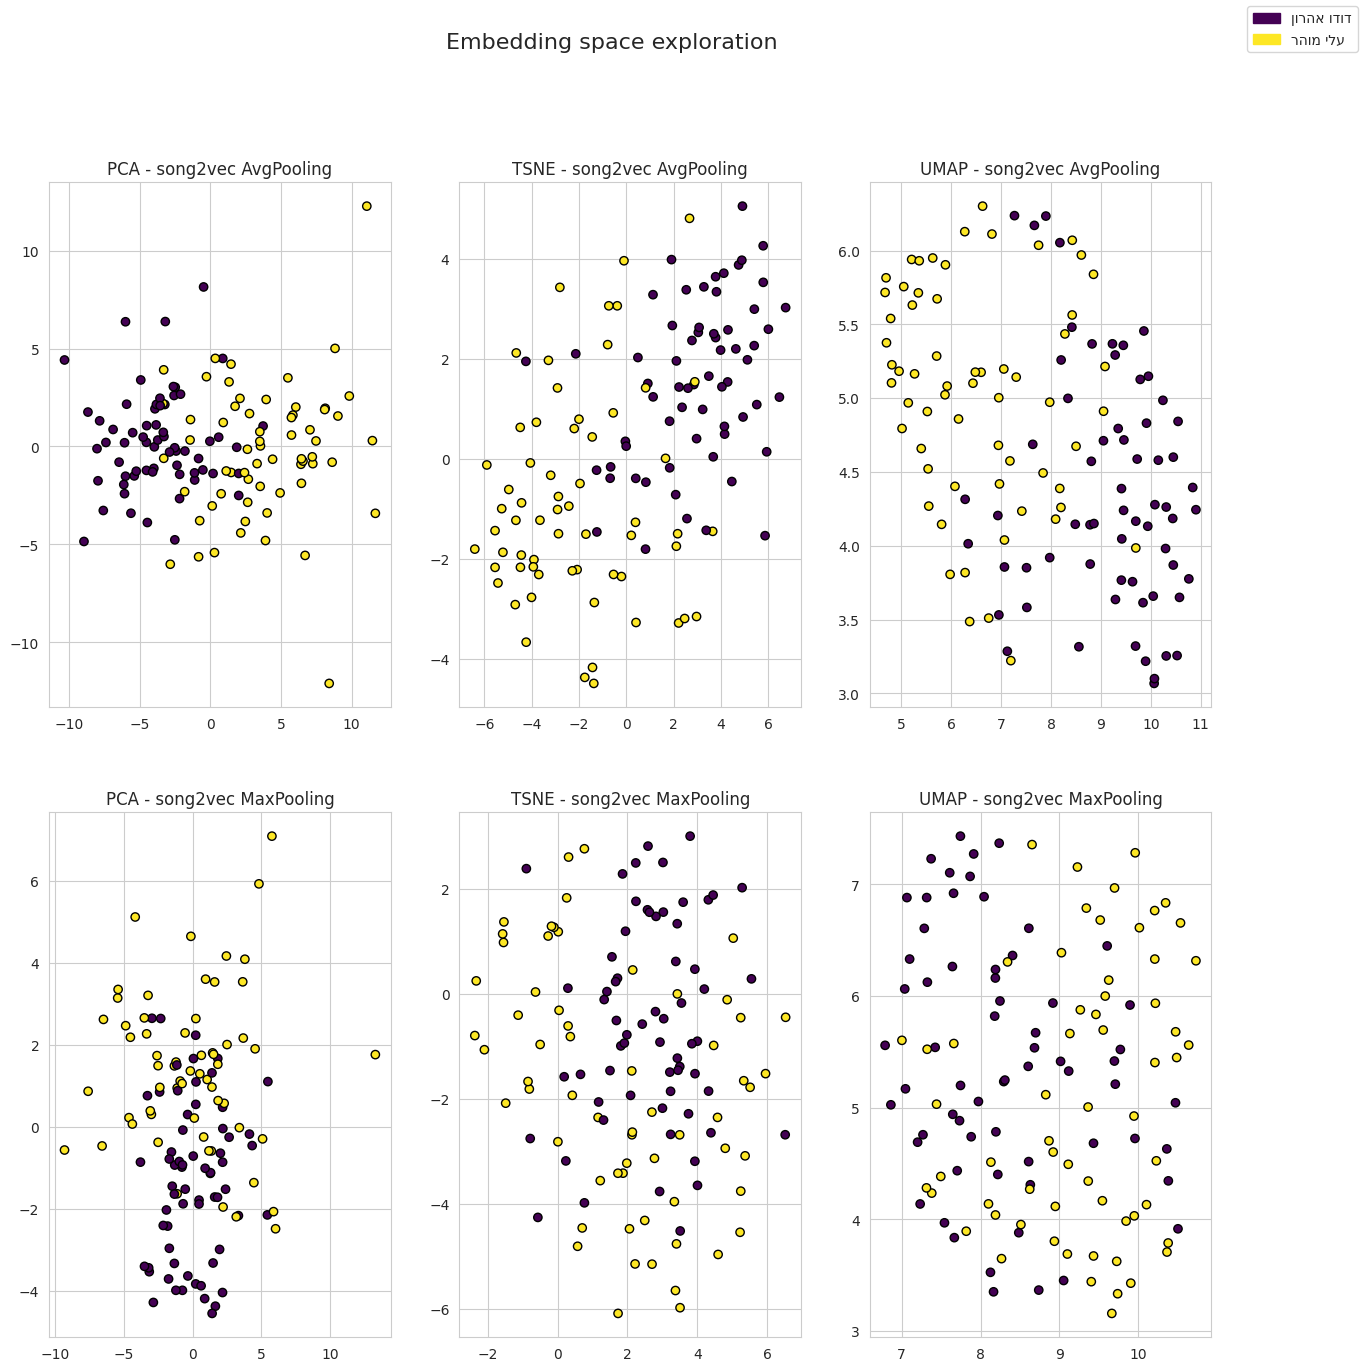

In [19]:
project_lyricists(["דודו אהרון", "עלי מוהר"])

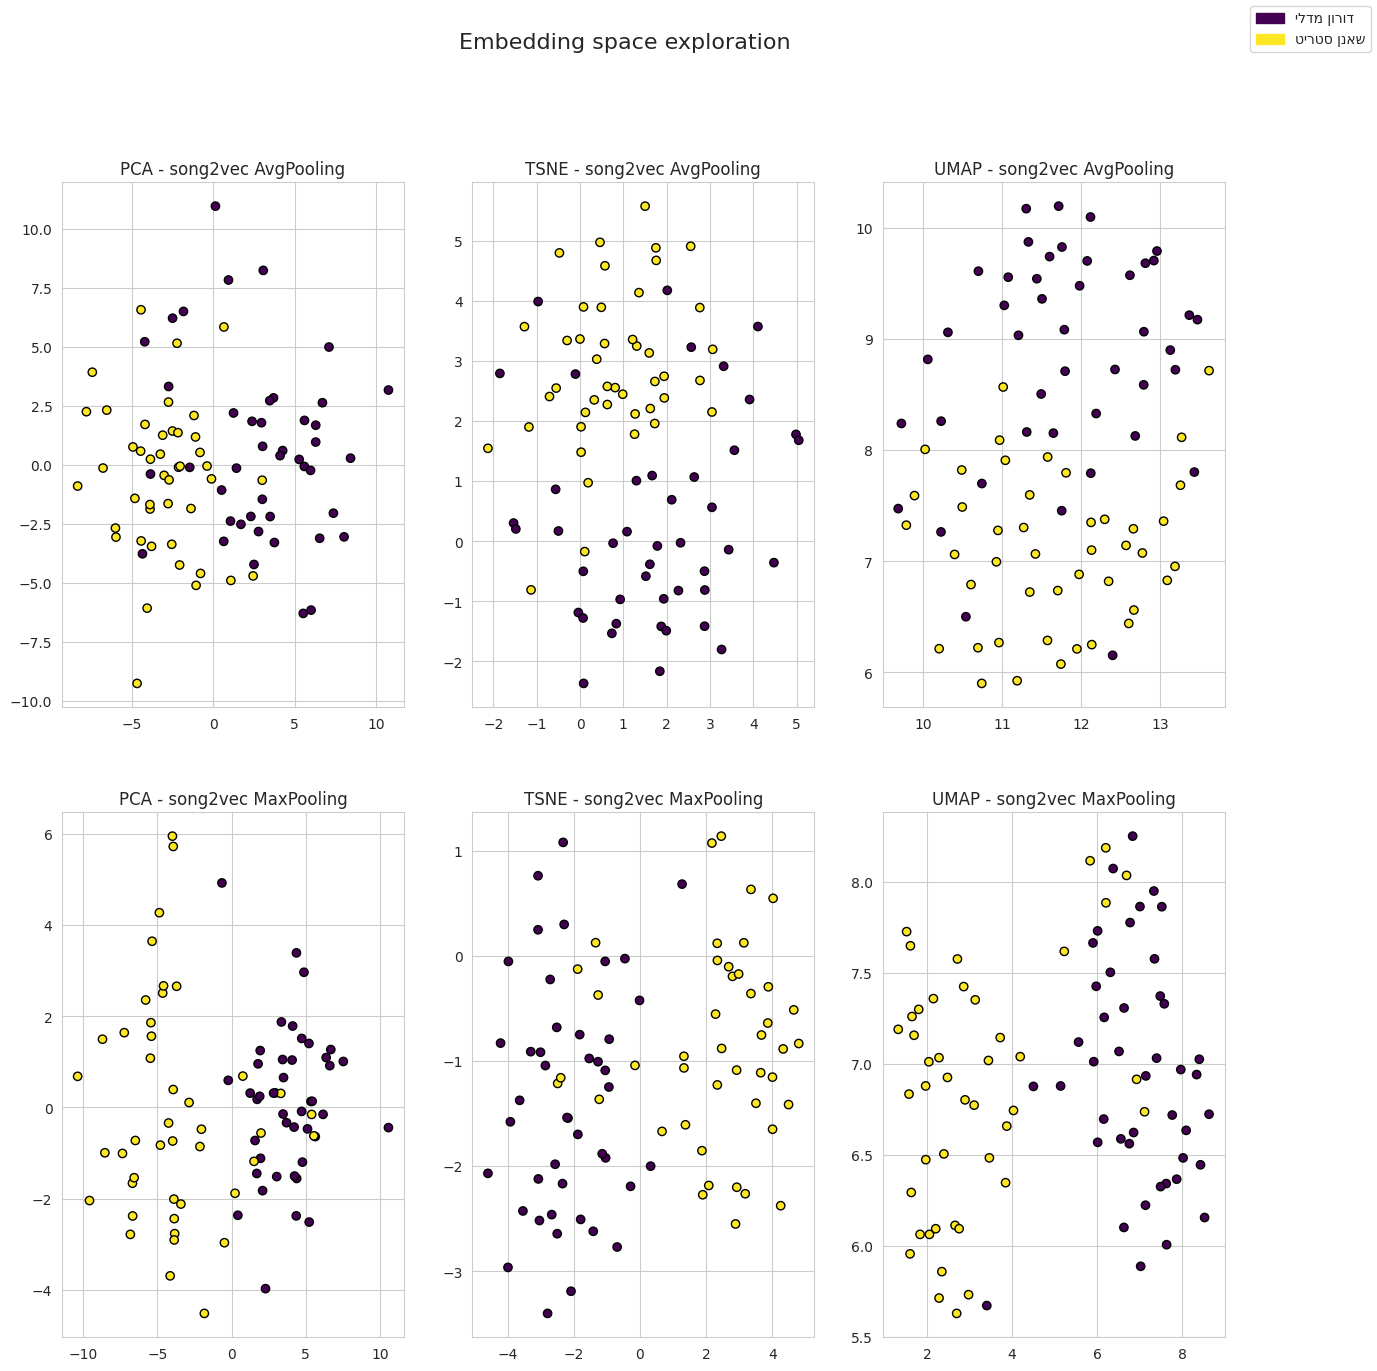

In [20]:
project_lyricists(["דורון מדלי", "שאנן סטריט"])

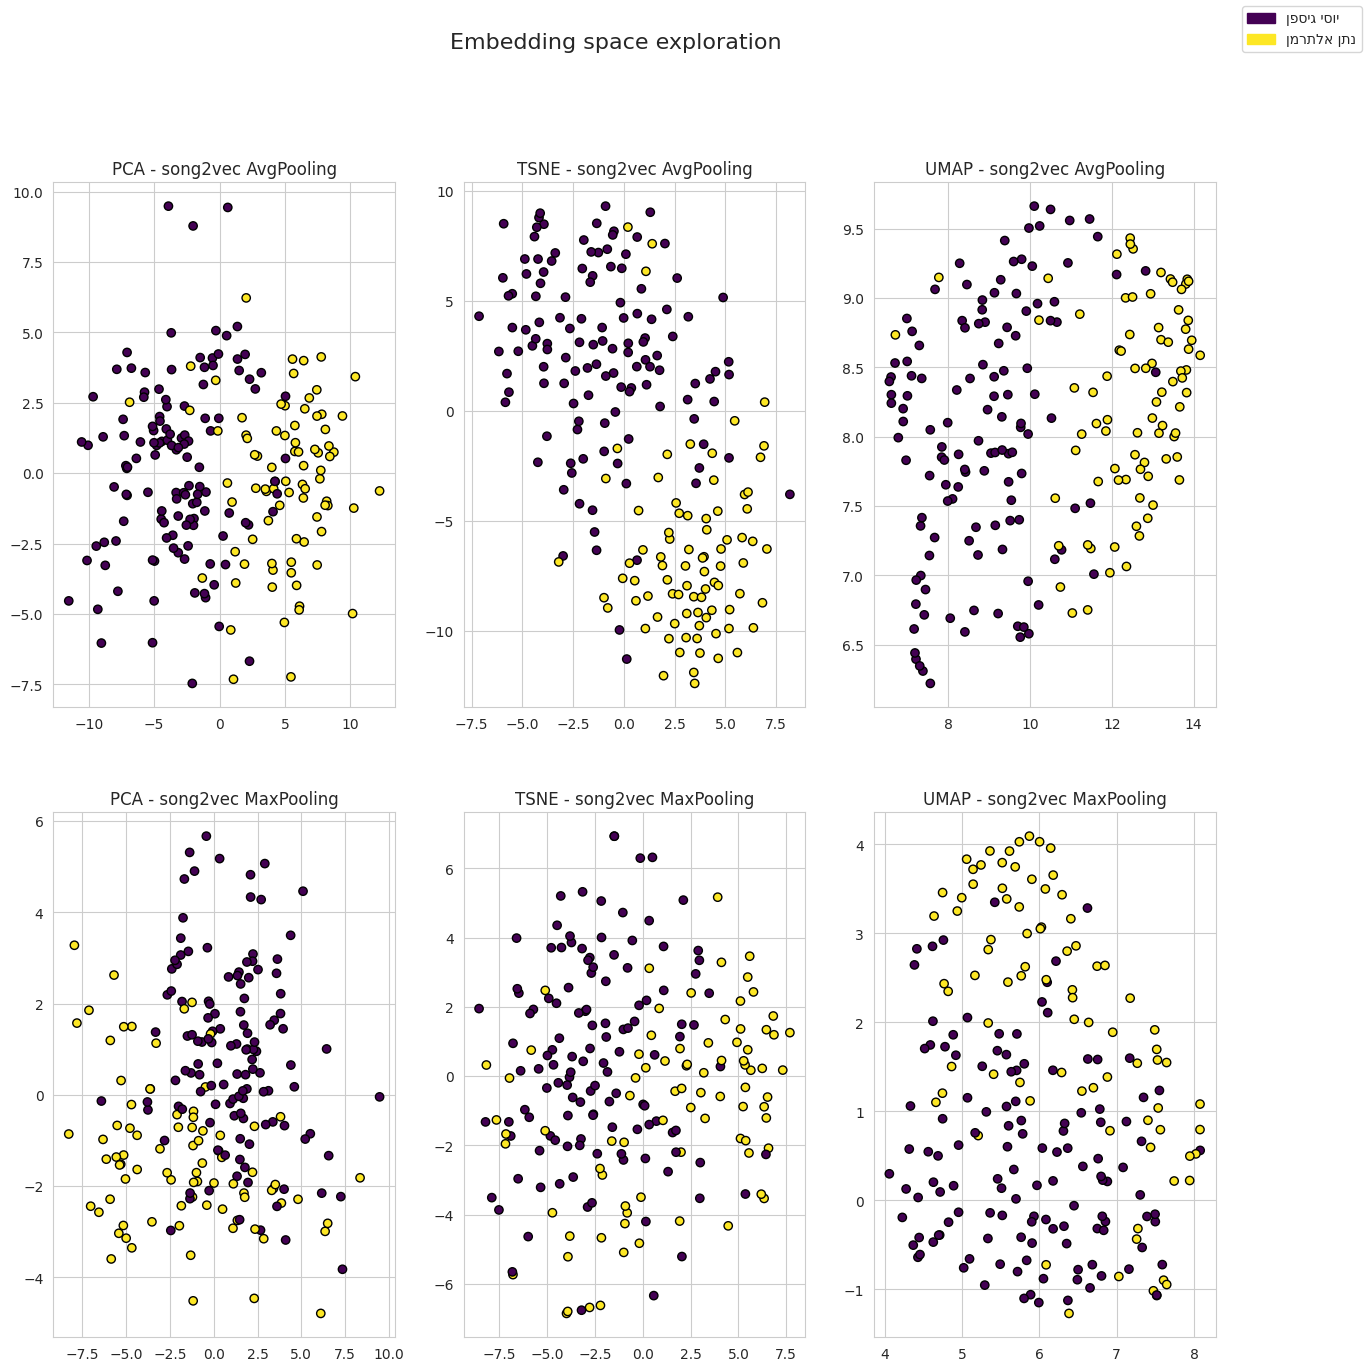

In [21]:
project_lyricists(["יוסי גיספן", "נתן אלתרמן"])

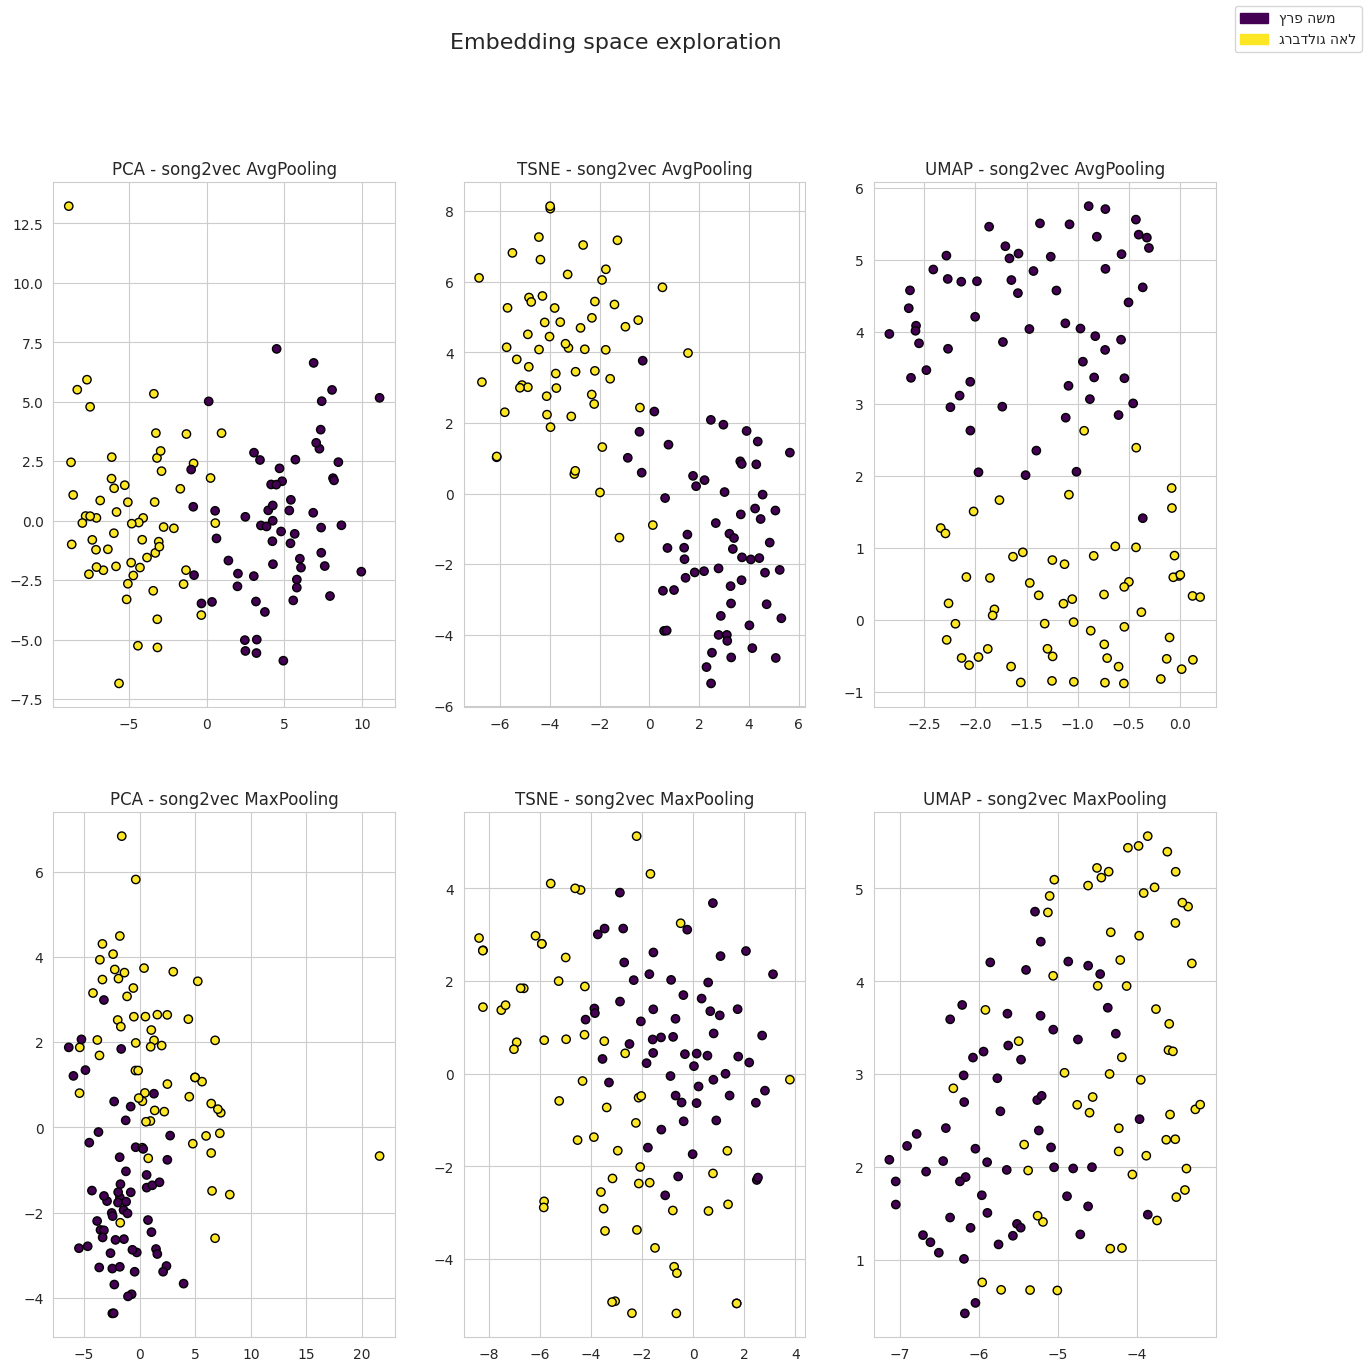

In [22]:
project_lyricists(["משה פרץ", "לאה גולדברג"])

Wow!
It seems that after scraping the dataset by our own, cleaning it, segmenting the lyrics, and changing the task to lyricist classification, instead of artist classification, the embedding space is a lot more separable.
As we can see, the song2vec average pooling embedding space is more separable than the song2vec max pooling embedding space, and so we will use it for our classification task.

# Classification experiments

In [202]:
from tabulate import tabulate
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score


def plot_confusion_matrix_hitmap(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def print_classification_report(y_test, y_pred, y_score=None):
    print('\n--------------- Classification Report ---------------\n')
    #we print a table of precision, recall, f1-score, support per class, and accuracy, macro avg, weighted avg overall

    c_report = classification_report(y_test, y_pred).split("\n", 1)
    print(c_report[0].split()[::-1])
    c_report_tail = c_report[1].split("\n")
    print("\n".join(c_report_tail[:-4]))
    print(tabulate([x.split() for x in c_report_tail[-3:]], headers=['', '', 'precision', 'recall', 'f1-score', 'support']))
    print("Top-1 Accuracy: ", c_report_tail[-4].split()[1])
    if y_score is not None:
        print("Top-5 Accuracy: ", top_k_accuracy_score(y_test, y_score, k=5))



X = np.array([np.array(w) for w in train_df['song2vec_mean']])
y = np.array(train_df['lyricist'])

X_test = np.array([np.array(w) for w in val_df['song2vec_mean']])
y_test = np.array(val_df['lyricist'])

## kNN
### Train

In [165]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 300, 5), 'metric': ['euclidean', 'cosine']}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
knn_gscv = GridSearchCV(knn, param_grid, cv=cv, scoring="f1_micro", error_score="raise", return_train_score=True, n_jobs=-1)
knn_res = knn_gscv.fit(X, y)
print("kNN:")
print(f"Best Params: {knn_res.best_params_}")  # Best Params: {'metric': 'euclidean', 'n_neighbors': 56}
print(f"Best f1 score for cross validation: {round(100 * knn_res.best_score_, 3)}")
print(f"Train f1 score: {round(100 * knn_res.cv_results_['mean_train_score'][knn_res.best_index_], 3)}")

kNN:
Best Params: {'metric': 'euclidean', 'n_neighbors': 56}
Best f1 score for cross validation: 11.284
Train f1 score: 13.69


### Validation


--------------- Classification Report ---------------

['support', 'f1-score', 'recall', 'precision']

     אבי אוחיון       0.14      0.58      0.23        24
       אביב גפן       0.00      0.00      0.00        25
     אביתר בנאי       0.00      0.00      0.00         9
    אהובה עוזרי       0.00      0.00      0.00        11
      אהוד בנאי       0.18      0.23      0.20        13
      אהוד מנור       0.24      0.17      0.20        54
      אופיר כהן       0.00      0.00      0.00         8
   אסף אמדורסקי       0.50      0.11      0.18         9
 אריק איינשטיין       0.00      0.00      0.00        13
      אריק ברמן       0.06      0.14      0.09        14
    ארקדי דוכין       0.00      0.00      0.00        13
      אתי אנקרי       0.00      0.00      0.00         8
    בצלאל אלוני       0.00      0.00      0.00        10
      גלעד כהנא       0.00      0.00      0.00        10
      דוד זיגמן       0.20      0.20      0.20        15
     דודו אהרון       0.19      0.55     

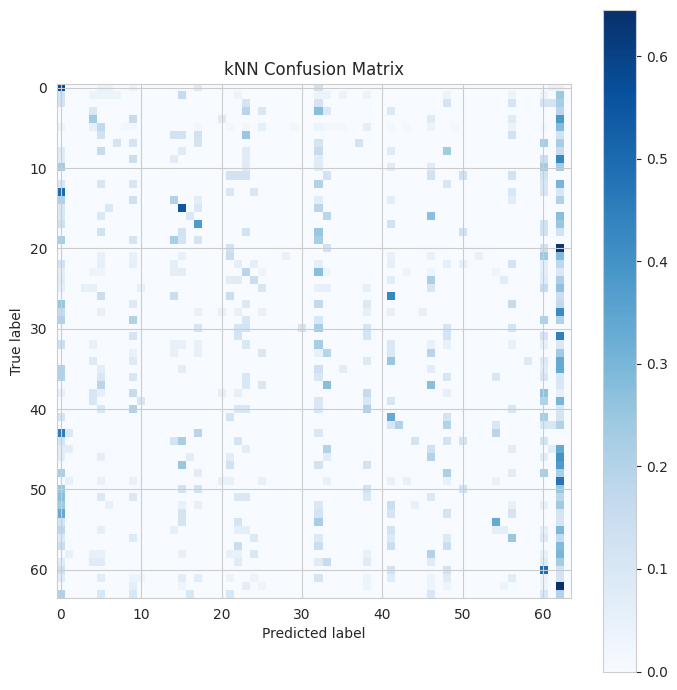

In [210]:
y_score = knn_res.best_estimator_.predict_proba(X_test)
y_pred = knn_res.best_estimator_.predict(X_test)
print_classification_report(y_test, y_pred, y_score)
plot_confusion_matrix_hitmap(y_test, y_pred, 'kNN Confusion Matrix')

## Polynomial kernel SVM
### Train

In [213]:
from sklearn.svm import SVC

svm = SVC(probability=True)
param_grid = {'C': np.logspace(0.01, 15, 10), 'kernel': ['poly'], 'degree': [2, 3, 4]}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
svm_gscv = GridSearchCV(svm, param_grid, cv=cv, scoring="f1_micro", error_score="raise", return_train_score=True, n_jobs=-1)
svm_res = svm_gscv.fit(X, y)
print("Polynomial kernel SVM:")
print(f"Best Params: {svm_res.best_params_}")  # Best Params: {'C': 2193.366020450619, 'degree': 4, 'kernel': 'poly'}
print(f"Best f1 score for cross validation: {round(100 * svm_res.best_score_, 3)}")
print(f"Train f1 score: {round(100 * svm_res.cv_results_['mean_train_score'][svm_res.best_index_], 3)}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Polynomial kernel SVM:
Best Params: {'C': 2193.366020450619, 'degree': 4, 'kernel': 'poly'}
Best f1 score for cross validation: 17.185
Train f1 score: 100.0


### Validation


--------------- Classification Report ---------------

['support', 'f1-score', 'recall', 'precision']

     אבי אוחיון       0.26      0.38      0.31        24
       אביב גפן       0.09      0.08      0.09        25
     אביתר בנאי       0.08      0.11      0.09         9
    אהובה עוזרי       0.33      0.36      0.35        11
      אהוד בנאי       0.09      0.15      0.11        13
      אהוד מנור       0.27      0.30      0.28        54
      אופיר כהן       0.00      0.00      0.00         8
   אסף אמדורסקי       0.25      0.22      0.24         9
 אריק איינשטיין       0.08      0.08      0.08        13
      אריק ברמן       0.33      0.36      0.34        14
    ארקדי דוכין       0.11      0.15      0.12        13
      אתי אנקרי       0.00      0.00      0.00         8
    בצלאל אלוני       0.17      0.10      0.12        10
      גלעד כהנא       0.20      0.10      0.13        10
      דוד זיגמן       0.21      0.27      0.24        15
     דודו אהרון       0.38      0.45     

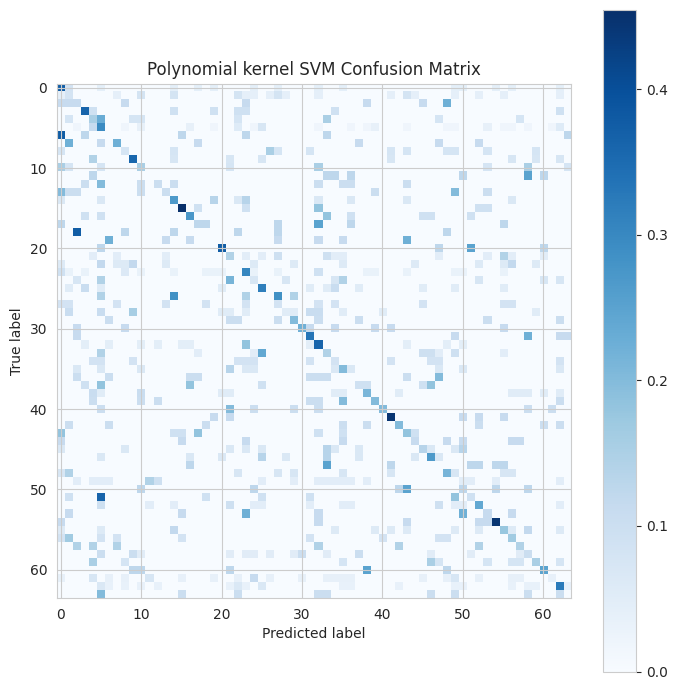

In [214]:
y_score = svm_res.best_estimator_.predict_proba(X_test)
y_pred = svm_res.best_estimator_.predict(X_test)
print_classification_report(y_test, y_pred, y_score)
plot_confusion_matrix_hitmap(y_test, y_pred, 'Polynomial kernel SVM Confusion Matrix')

## RBF kernel SVM
### Train

In [215]:
from sklearn.svm import SVC

svm = SVC(probability=True)
param_grid = {'C': np.logspace(0.1, 15, 10), 'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 'class_weight': ['balanced', None]}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
svm_gscv = GridSearchCV(svm, param_grid, cv=cv, scoring="f1_micro", error_score="raise", return_train_score=True, n_jobs=-1)
svm_res = svm_gscv.fit(X, y)
print("RBF kernel SVM:")
print(f"Best Params: {svm_res.best_params_}")  # Best Params: {'C': 56.958108107376894, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
print(f"Best f1 score for cross validation: {100 * svm_res.best_score_}")
print(f"Train f1 score: {100 * svm_res.cv_results_['mean_train_score'][svm_res.best_index_]}")

Fitting 3 folds for each of 40 candidates, totalling 120 fits
RBF kernel SVM:
Best Params: {'C': 56.958108107376894, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Best f1 score for cross validation: 18.417639429312583
Train f1 score: 57.16244497365952


### Validation


--------------- Classification Report ---------------

['support', 'f1-score', 'recall', 'precision']

     אבי אוחיון       0.21      0.42      0.28        24
       אביב גפן       0.16      0.20      0.18        25
     אביתר בנאי       0.00      0.00      0.00         9
    אהובה עוזרי       0.44      0.36      0.40        11
      אהוד בנאי       0.11      0.15      0.12        13
      אהוד מנור       0.18      0.39      0.25        54
      אופיר כהן       0.00      0.00      0.00         8
   אסף אמדורסקי       0.40      0.22      0.29         9
 אריק איינשטיין       0.00      0.00      0.00        13
      אריק ברמן       0.29      0.36      0.32        14
    ארקדי דוכין       0.11      0.08      0.09        13
      אתי אנקרי       0.00      0.00      0.00         8
    בצלאל אלוני       0.50      0.20      0.29        10
      גלעד כהנא       0.00      0.00      0.00        10
      דוד זיגמן       0.22      0.27      0.24        15
     דודו אהרון       0.40      0.36     

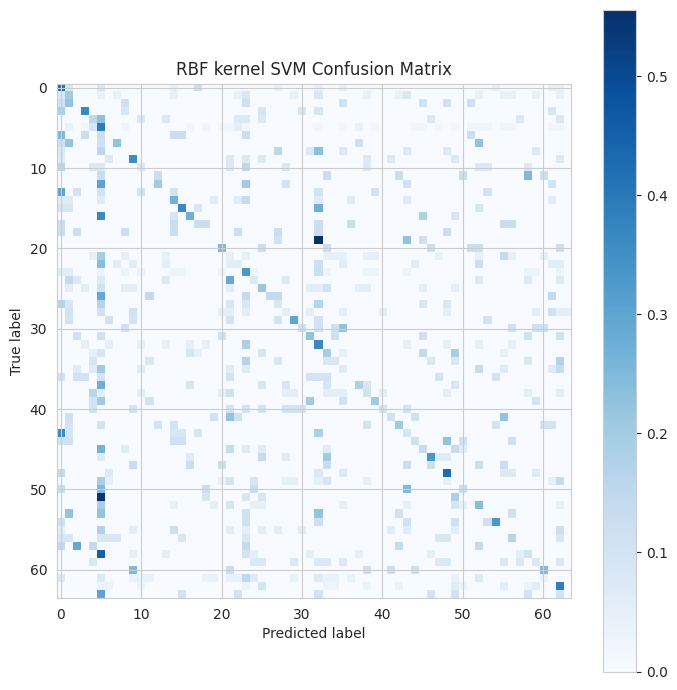

In [216]:
y_score = svm_res.best_estimator_.predict_proba(X_test)
y_pred = svm_res.best_estimator_.predict(X_test)
print_classification_report(y_test, y_pred, y_score)
plot_confusion_matrix_hitmap(y_test, y_pred, 'RBF kernel SVM Confusion Matrix')

## Naive Bayes AdaBoost
### Train

In [219]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

gnb = GaussianNB()
ada = AdaBoostClassifier(base_estimator=gnb)
param_grid = {'n_estimators': np.arange(10, 100, 10), 'learning_rate': np.arange(0.1, 1, 0.1)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
ada_gscv = GridSearchCV(ada, param_grid, cv=cv, scoring="f1_micro", error_score="raise", return_train_score=True, n_jobs=-1)
ada_res = ada_gscv.fit(X, y)
print("Naive Bayes AdaBoost:")
print(f"Best Params: {ada_res.best_params_}")  #Best Params:
print(f"Best f1 score for cross validation: {round(100 * ada_res.best_score_, 3)}")
print(f"Train f1 score: {round(100 * ada_res.cv_results_['mean_train_score'][ada_res.best_index_], 3)}")

/home/idan/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/idan/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/idan/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/idan/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/idan/.local/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/idan/.loc

KeyboardInterrupt: 

### Validation

In [ ]:
y_score = ada_res.best_estimator_.predict_proba(X_test)
y_pred = ada_res.best_estimator_.predict(X_test)
print_classification_report(y_test, y_pred, y_score)
plot_confusion_matrix_hitmap(y_test, y_pred, 'Naive Bayes AdaBoost Confusion Matrix')

## lightGBM
### Train

In [ ]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()
param_grid = {'n_estimators': np.arange(10, 100, 10), 'learning_rate': np.arange(0.1, 1, 0.1), 'num_leaves': np.arange(10, 100, 10), 'max_depth': np.arange(10, 100, 10)}
cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
lgbm_gscv = GridSearchCV(lgbm, param_grid, cv=cv, scoring="f1_micro", error_score="raise", return_train_score=True, n_jobs=-1)
lgbm_res = lgbm_gscv.fit(X, y)
print("lightGBM:")
print(f"Best Params: {lgbm_res.best_params_}")  # Best Params:
print(f"Best f1 score for cross validation: {round(100 * lgbm_res.best_score_, 3)}")
print(f"Train f1 score: {round(100 * lgbm_res.cv_results_['mean_train_score'][lgbm_res.best_index_], 3)}")

### Validation

In [ ]:
y_score = lgbm_res.best_estimator_.predict_proba(X_test)
y_pred = lgbm_res.best_estimator_.predict(X_test)
print_classification_report(y_test, y_pred, y_score)
plot_confusion_matrix_hitmap(y_test, y_pred, 'lightGBM Confusion Matrix')

# RNNs

In [ ]:
words_set.add('</s>')
# [[w2v[w] for w in song if w in words_set] for song in train_df['lyrics'].to_list()] # too heavy

In [26]:
from torch.nn import CrossEntropyLoss, Linear, ReLU, Sequential, Softmax

X_train = train_df['lyrics']

def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, lr=0.001, weight_decay=0.0,
                verbose=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = CrossEntropyLoss()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            batch = X_train[i:i + batch_size]
            labels = y_train[i:i + batch_size]
            outputs = model(batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(dim=1) == labels).sum().item()
        train_loss /= len(X_train)
        train_acc /= len(X_train)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch = X_val[i:i + batch_size]
                labels = y_val[i:i + batch_size]
                outputs = model(batch)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += (outputs.argmax(dim=1) == labels).sum().item()
        val_loss /= len(X_val)
        val_acc /= len(X_val)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if verbose:
            print(f'Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.3f}, train acc: {train_acc:.3f}, '
                  f'val loss: {val_loss:.3f}, val acc: {val_acc:.3f}')


## LSTM
### Train

In [ ]:
from torch.nn import LSTM

model = Sequential(
    LSTM(100, input_size=(X.shape[1], X.shape[2]), batch_first=True),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, 16),
    ReLU(),
    Linear(16, 2),
    Softmax(dim=1)
)

## GRU
### Train

In [ ]:
from torch.nn import GRU



### Validation